# Mid-Atlantic Beer Data

## Data Gathering

#### The Universe of Beer Reviews and Beer-Related Databases

There is a bevy of beer review data on the Internet. Some of the main beer review website/applications include: 
* [BeerAdvocate](https://www.beeradvocate.com) 
* [RateBeer](https://www.ratebeer.com)
* [Untappd](https://untappd.com/home)

Additionally, there are more specialized Beer-focused publications that include reviews, typically with a more limited selection of esoteric or limited-release beers:
* [The Beer Connoiseur](https://beerconnoisseur.com)
* [Craft Beer and Brewing](https://beerandbrewing.com)
* [The Full Pint](https://thefullpint.com/beer-reviews/)
* [All About Beer](http://allaboutbeer.com)
* [Draft Magazine](https://draftmag.com)

General brewery databases:
* [Open Brewery DB](https://www.openbrewerydb.org)
* [BreweryDB](https://www.brewerydb.com/developers)

Both [RateBeer](https://www.ratebeer.com/api-documentation.asp) and [Untappd](https://untappd.com/api/register#) have developer APIs, but both require explicit approval for API keys. Untappd in particular places restrictions on API access for pure research and analytics purposes. Given the turnaround time for API key access, I'm relying heavily on web scraping, which is not explicitly prohibited per each website's Robots Exclusion Protocol page. I have avoided scraping BeerAdvocate given reports of the owner's proclivity towards legal action against prior web scrapers.

In addition to scraping beer review data, I've also incorporated data from the very cool beer databases [Open Brewery DB](https://www.openbrewerydb.org) and [BreweryDB](https://www.brewerydb.com).

#### Beer Style Guidelines

BJCP vs Brewers Association

TK

## Data Processing and Exploration

I created a web-scraping script which scrapes all the beers and its associated characteristics (name, style, ABV, aggregate RateBeer rating, date added to RateBeer) from each brewery in a given url associated with a specific region. For this analysis I'm restricting my scope to breweries within Delaware, Maryland, Virginia, Washington D.C., and West Virginia.



The web scraping script outputted separate csv files for each state composed of all beers from breweries in that state.

In [1]:
# Import pandas, numpy for data cleaning and viz
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.options.display.max_columns = 5_000 # So I can see all the columns rather than just ...

### Reading and Cleaning Beer Listing Data from RateBeer

In [2]:
# Reading in and combining .CSVs
de = pd.read_csv('../data/brewlist_DE.csv')
md = pd.read_csv('../data/brewlist_MD.csv')
va = pd.read_csv('../data/brewlist_VA.csv')
dc = pd.read_csv('../data/brewlist_DC.csv')
wv = pd.read_csv('../data/brewlist_WV.csv')

mid_atl_beers = pd.concat([de, md, va, dc, wv], ignore_index=True)

In [3]:
# Inspect initial rows
mid_atl_beers.head()

,abv,brewery,date_added,link,name,num_ratings,rating,style,style_rating
0,0.100,38-75 Brewing,8/27/2018,www.ratebeer.com/beer/38-75-crooked-hammock-ba...,38-75 / Crooked Hammock Balance Beam,0,NaN,Stout - Imperial,NaN
1,0.065,38-75 Brewing,8/27/2018,www.ratebeer.com/beer/38-75-dewey-beer-co-kick...,38-75 / Dewey Beer Co. Kick it IPA,0,NaN,IPA,NaN
2,0.065,38-75 Brewing,8/27/2018,www.ratebeer.com/beer/38-75-3pacs-ipa/652451/,38-75 3PAC's IPA,0,NaN,IPA,NaN
3,0.072,38-75 Brewing,8/27/2018,www.ratebeer.com/beer/38-75-biggie-shorty-ipa/...,38-75 Biggie Shorty IPA,0,NaN,IPA,NaN
4,0.056,38-75 Brewing,8/27/2018,www.ratebeer.com/beer/38-75-cranberry-sauced-p...,38-75 Cranberry Sauce'd Pale Ale,0,NaN,Pale Ale - American / APA,NaN


In [4]:
# Summary of all beer data in chosen states
mid_atl_beers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20389 entries, 0 to 20388
Data columns (total 9 columns):
abv             19003 non-null float64
brewery         20389 non-null object
date_added      20389 non-null object
link            20389 non-null object
name            20389 non-null object
num_ratings     20389 non-null int64
rating          15329 non-null float64
style           20389 non-null object
style_rating    2940 non-null float64
dtypes: float64(3), int64(1), object(5)
memory usage: 1.4+ MB


Looking at the columns in the beer dataframe, all the data types seem to be the correct data type. However there might be some issues with spacing with the string/object columns.

In [5]:
# Example of extra spacing
mid_atl_beers['brewery'][0]

' 38-75 Brewing'

In [6]:
mid_atl_beers['brewery'].dtype == 'O'

True

In [7]:
def strip_col(df, col):
    """
    Trim whitepace on specified columns of object dtype.
    
    Parameters
    ----------
    df : pandas dataframe
    col : specified name of column (str)

    Returns
    -------
    revised pandas dataframe

    """
    if df[col].dtype == 'O':
        df[col] = df[col].map(lambda x: x.strip())
    else:
        print("The specified column is not an object (string) datatype.")
    return df

In [8]:
# Some columns have extra white space
strip_col(mid_atl_beers, 'brewery')
strip_col(mid_atl_beers, 'name')
strip_col(mid_atl_beers, 'style');

### Reading and Cleaning Additional Information from Open Brewery DB API

In [9]:
# Pulling in listing of all current breweries in USA listed in Open Brewery DB
# Dropped extraneous columns ('Unnamed: 0' and 'tag_list')
usa_breweries = pd.read_csv('../data/usa_breweries.csv').drop(columns=['Unnamed: 0', 'tag_list'])

In [10]:
# Inspect head of usa breweries
usa_breweries.head(5)

,brewery_type,city,country,id,latitude,longitude,name,phone,postal_code,state,street,updated_at,website_url
0,micro,Birmingham,United States,2,33.524521,-86.774322,Avondale Brewing Co,2.057775e+09,35222-1932,Alabama,201 41st St S,2018-08-23T23:19:57.825Z,http://www.avondalebrewing.com
1,micro,Tuscaloosa,United States,4,33.198491,-87.562155,Band of Brothers Brewing Company,2.052665e+09,35401-4653,Alabama,1605 23rd Ave,2018-08-23T23:19:59.462Z,http://www.bandofbrosbrewing.com
2,micro,Birmingham,United States,44,33.512849,-86.791400,Trim Tab Brewing,2.057031e+09,35233-3401,Alabama,2721 5th Ave S,2018-08-23T23:20:31.423Z,http://www.trimtabbrewing.com
3,micro,Huntsville,United States,46,34.727752,-86.593201,Yellowhammer Brewery,2.569756e+09,35805-3046,Alabama,2600 Clinton Ave W,2018-08-23T23:20:33.102Z,http://www.yellowhammerbrewery.com
4,micro,Gadsden,United States,3,34.016888,-86.005006,Back Forty Beer Co,2.564675e+09,35901-3361,Alabama,200 N 6th St,2018-08-23T23:19:58.654Z,http://www.backfortybeer.com


In [11]:
# All 50 states and DC
usa_breweries['state'].unique()

array(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
       'Colorado', 'Connecticut', 'Delaware', 'Florida', 'Georgia',
       'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas',
       'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts',
       'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana',
       'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico',
       'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma',
       'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont',
       'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming',
       'District of Columbia'], dtype=object)

In [12]:
# Renaming certain columns for clarity when joining
usa_breweries.rename(columns={'id':'openbrewdb_id', 'name':'brewery'}, inplace=True)

In [13]:
# Convert phone numbers to string and clip trailing ".0"
usa_breweries['phone'] = usa_breweries['phone'].map(lambda x: str(x)[:-2]).map(lambda x: np.nan if x == 'n' else x)

In [14]:
# inspecting datatypes
usa_breweries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6939 entries, 0 to 6938
Data columns (total 13 columns):
brewery_type     6939 non-null object
city             6939 non-null object
country          6939 non-null object
openbrewdb_id    6939 non-null int64
latitude         4612 non-null float64
longitude        4612 non-null float64
brewery          6939 non-null object
phone            6362 non-null object
postal_code      6939 non-null object
state            6939 non-null object
street           6845 non-null object
updated_at       6939 non-null object
website_url      6052 non-null object
dtypes: float64(2), int64(1), object(10)
memory usage: 704.8+ KB


### Joining dataframes / Initial exploratory analysis

In [15]:
# Joining mid-atl-beers df with usa_breweries df on brewery names
mid_atl_beers_expanded = pd.merge(mid_atl_beers, usa_breweries, how='inner', left_on='brewery', right_on='brewery')

In [16]:
# Info of joined dataframe
mid_atl_beers_expanded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10950 entries, 0 to 10949
Data columns (total 21 columns):
abv              10401 non-null float64
brewery          10950 non-null object
date_added       10950 non-null object
link             10950 non-null object
name             10950 non-null object
num_ratings      10950 non-null int64
rating           8052 non-null float64
style            10950 non-null object
style_rating     1339 non-null float64
brewery_type     10950 non-null object
city             10950 non-null object
country          10950 non-null object
openbrewdb_id    10950 non-null int64
latitude         7022 non-null float64
longitude        7022 non-null float64
phone            9432 non-null object
postal_code      10950 non-null object
state            10950 non-null object
street           10941 non-null object
updated_at       10950 non-null object
website_url      10177 non-null object
dtypes: float64(5), int64(2), object(14)
memory usage: 1.8+ MB


In [17]:
# Num of ratings column is hugely skewed
mid_atl_beers_expanded['num_ratings'].describe()

count    10950.000000
mean         7.389041
std         61.207205
min          0.000000
25%          0.000000
50%          1.000000
75%          4.000000
max       2607.000000
Name: num_ratings, dtype: float64

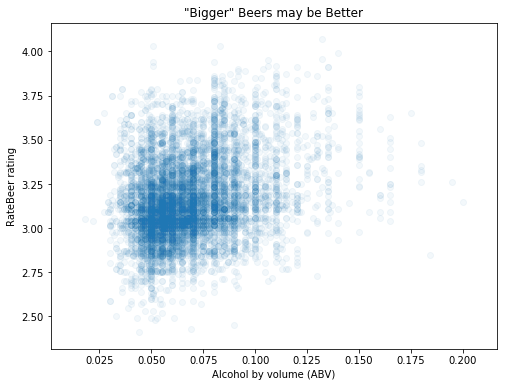

In [18]:
# Not such a clear relationship, but maybe people tend to rate 'bigger' beers better 
# and most beers are in 4-9% abv range
plt.figure(figsize=(8,6))
plt.scatter(x=mid_atl_beers_expanded['abv'], y=mid_atl_beers_expanded['rating'], alpha=0.05)
plt.xlabel('Alcohol by volume (ABV)')
plt.ylabel('RateBeer rating')
plt.title('"Bigger" Beers may be Better');

In [19]:
# Top Beer styles by count
mid_atl_beers_expanded['style'].value_counts().head(20)

IPA                              1294
IIPA - Imperial / Double IPA      994
Saison / Farmhouse / Grisette     678
Stout - Imperial                  630
Pale Ale - American / APA         509
Sour / Wild Beer                  498
Porter                            307
Flavored - Other                  275
Brown Ale                         260
Gose                              255
Stout                             253
Stout - Milk / Sweet              236
Wheat Ale                         235
Belgian Ale - Pale / Golden       226
IPA - Hazy / NEIPA                213
Berliner Weisse                   209
Blonde Ale / Golden Ale           199
Flavored - Fruit                  184
Red Ale / Intl Amber Ale          176
Belgian Ale - Strong Pale         152
Name: style, dtype: int64

In [20]:
# Some summary stats by style
mid_atl_beers_expanded.groupby('style')['rating'].agg(['mean','std','min','max']).T

style,Altbier / Sticke Alt,Amber Lager - Intl / Vienna,Apple Cider,BarleyWine / WheatWine / RyeWine,Belgian Ale - Pale / Golden,Belgian Ale - Strong Dark,Belgian Ale - Strong Pale,Berliner Weisse,Berliner Weisse - Flavored,Bitter - Ordinary / Best,Bitter - Premium / Strong / ESB,Bière de Garde / de Mars,Blonde Ale / Golden Ale,Bock - Doppelbock,Bock - Dunkler Bock,Bock - Eisbock,Bock - Weizenbock,Bock- Heller Bock / Maibock,Brown Ale,California Common / Steam Beer,Cream Ale,Dark Lager - Dunkel / Tmavý,Dubbel,Flavored - Chili / Peppers,Flavored - Fruit,Flavored - Other,Flavored - Pumpkin / Vegetables,Gose,Gose - Flavored,Gotlandsdricke/ Koduõlu/ Sahti,Helles / Dortmunder Export,IIPA - Imperial / Double IPA,IIPA - Imperial Hazy / NEIPA,IPA,IPA - Belgian,IPA - Black/Brown/Cascadian Dark,IPA - Brut,IPA - Flavored,IPA - Hazy / NEIPA,IPA - Milkshake,IPA - Red,IPA - Rye,IPA - Sour / Wild,ISA - Session IPA,Kölsch / Kölsch-Style,Lambic - Fruited,Low / No Alcohol Beer,Malt Liquor,Mead,Mild Ale,Märzen / Oktoberfest Bier,Old Ale,Pale Ale - American / APA,Pale Ale - Australia / NZ,Pale Ale - Belgian,Pale Ale - English,Pale Lager - India / Hoppy,Pale Lager - Intl / Premium,Pale Lager - North Am. / Light,Pale Lager - Strong,Pilsener - Czech / Svetlý,Pilsener - Imperial,Pilsener / Pils / Pilsner,Porter,Porter - Baltic,Porter - Imperial,Quadrupel / Abt,Radler / Shandy,Red Ale - Imperial,Red Ale - Irish,Red Ale / Intl Amber Ale,Saison / Farmhouse / Grisette,Saison/Farmhouse - Flavored,Schwarzbier / Black Lager,Scotch Ale / Wee Heavy,Scottish Ale,Smoked - Other,Smoked - Rauchbier,Sour - Flanders Red / Bruin,Sour / Wild Beer,Sour / Wild Beer - Flavored,Sour/Wild - Dark,Specialty Grain - Other,Stout,Stout - Dry,Stout - Extra / Foreign,Stout - Imperial,Stout - Imperial Flavored,Stout - Milk / Sweet,Stout - Oatmeal,Strong Ale - American,Strong Ale - English,Traditional Ale - Other,Tripel,Weissbier - Dunkelweizen,Weissbier - Hefeweizen,Weissbier - Kristallweizen,Wheat Ale,Witbier / Belgian White Ale,Zwickelbier/Kellerbier/Landbier
mean,3.093684,3.008000,3.036667,3.234048,3.071138,3.53500,3.109558,3.212485,3.511905,2.97500,3.031818,3.222162,3.015000,3.187742,2.980000,NaN,3.053182,3.099394,3.038563,3.044000,2.992157,3.058000,3.049231,3.175000,3.010602,3.067536,3.216667,3.199036,3.595000,3.172500,2.999697,3.309724,3.457200,3.157135,3.73,3.160978,3.010000,3.171667,3.297065,3.26000,3.14,3.06,3.193333,3.102453,2.992361,3.33,3.04,3.062000,3.044286,3.061875,3.021864,3.192000,3.102189,3.04,3.31,3.020000,3.195385,3.073235,2.922222,3.15,3.08875,3.111000,3.060941,3.120981,3.215000,3.270690,3.201633,2.887647,2.990000,2.988605,3.023226,3.127365,3.220000,3.105161,3.162500,2.958929,3.71,3.118868,3.137407,3.223317,3.210000,NaN,3.065000,3.147235,3.109792,3.348500,3.317051,3.342500,3.208950,3.080000,3.141000,3.042500,3.093929,3.112136,2.965152,3.028750,2.866667,3.080988,3.078452,3.205833
std,0.177864,0.175035,0.128582,0.216217,0.185808,0.13435,0.189950,0.198308,0.228596,0.15167,0.133961,0.193565,0.193736,0.199009,0.182688,NaN,0.179029,0.162960,0.173838,0.177796,0.128333,0.138928,0.147673,0.162635,0.184123,0.194013,0.341223,0.208470,0.206228,0.139566,0.138304,0.241597,0.330373,0.194537,NaN,0.222009,0.042426,0.202624,0.234693,0.19799,NaN,NaN,0.186405,0.165333,0.154085,NaN,NaN,0.091761,0.070441,0.181760,0.141695,0.214981,0.187441,NaN,NaN,0.130325,0.199283,0.166182,0.196819,NaN,0.20556,0.148058,0.180803,0.197028,0.220127,0.210978,0.244228,0.138317,0.103923,0.154451,0.184415,0.168544,0.254558,0.162888,0.221902,0.165984,NaN,0.199458,0.196701,0.217690,0.292062,NaN,0.198721,0.178770,0.158080,0.278271,0.253200,0.201887,0.216011,0.193132,0.190403,0.108463,0.218773,0.172084,0.120575,0.176276,0.285715,0.193815,0.165096,0.202774
min,2.850000,2.610000,2.890000,2.730000,2.530000,3.44000,2.770000,2.700000,3.000000,2.57000,2.760000,2.890000,2.530000,2.770000,2.710000,NaN,2.770000,2.690000,2.480000,2.700000,2.610000,2.760000,2.570000,3.060000,2.580000,2.450000,2.860000,2.640000,3.150000

### Data export for further analysis

In [21]:
# Export of full beer listing dataframe
mid_atl_beers_expanded.to_csv('../data/full_midatlantic_beerlist.csv', index=False)

In [22]:
# How many beers have at least 5 reviews/ratings?
mid_atl_beers_expanded[mid_atl_beers_expanded['num_ratings'] > 5].shape

(1996, 21)

In [23]:
# Filtered by number of ratings available
mid_atl_beers_with_ratings = mid_atl_beers_expanded[mid_atl_beers_expanded['num_ratings'] > 5][['name','link']]

In [24]:
# Export of filtered beer list for additional scraping and analysis
mid_atl_beers_with_ratings.to_csv('../data/textualanalysis_beers.csv')